In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.express as px
from heatmap import corrplot

# Load data
Load weather dataset and drop duplicates

In [2]:
raw = pd.read_csv('../../VEOLIA/artifacts/weather_bulk.csv').drop_duplicates(subset=['dt'])
raw.head(3)

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,...,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1591747200,2020-06-10 00:00:00 +0000 UTC,7200,Burgos,42.3503,-3.7072,5.51,2.72,4.94,7.03,...,30,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
1,1591750800,2020-06-10 01:00:00 +0000 UTC,7200,Burgos,42.3503,-3.7072,5.13,2.97,4.88,6.53,...,40,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
2,1591754400,2020-06-10 02:00:00 +0000 UTC,7200,Burgos,42.3503,-3.7072,5.73,2.99,5.28,6.47,...,50,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n


In [3]:
raw.describe()

,dt,timezone,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id
count,9.744000e+03,9744.000000,9.744000e+03,9744.0000,9744.000000,9744.000000,9744.000000,9744.000000,9744.000000,0.0,0.0,9744.000000,9744.000000,9744.000000,664.000000,142.000000,19.000000,1.0,9744.000000,9744.000000
mean,1.609285e+09,5834.482759,4.235030e+01,-3.7072,11.232869,9.626817,9.789386,12.848294,1018.587028,NaN,NaN,76.024733,4.378810,123.084360,1.075377,1.788732,0.957895,0.2,37.286535,762.721983
std,1.012678e+07,1746.865165,7.105792e-15,0.0000,7.600683,8.571418,7.706588,8.029855,6.651901,NaN,NaN,21.067666,2.499148,95.112421,0.998904,2.069265,0.183533,NaN,35.877178,102.305829
min,1.591747e+09,3600.000000,4.235030e+01,-3.7072,-6.990000,-12.540000,-11.470000,-5.200000,992.000000,NaN,NaN,8.000000,0.000000,0.000000,0.130000,0.200000,0.200000,0.2,0.000000,200.000000
25%,1.600516e+09,3600.000000,4.235030e+01,-3.7072,5.950000,3.130000,4.730000,7.130000,1015.000000,NaN,NaN,63.000000,2.570000,40.000000,0.560000,0.400000,1.000000,0.2,0.000000,800.000000
50%,1.609285e+09,7200.000000,4.235030e+01,-3.7072,10.320000,9.620000,8.980000,11.980000,1019.000000,NaN,NaN,82.000000,4.100000,70.000000,1.000000,1.000000,1.000000,0.2,20.000000,800.000000
75%,1.618053e+09,7200.000000,4.235030e+01,-3.7072,15.752500,15.220000,14.680000,17.730000,1023.000000,NaN,NaN,93.000000,6.200000,210.000000,1.000000,3.000000,1.000000,0.2,75.000000,802.000000
max,1.626822e+09,7200.000000,4.235030e+01,-3.7072,37.020000,34.810000,35.940000,38.130000,1038.000000,NaN,NaN,100.000000,15.400000,360.000000,8.250000,14.000000,1.000000,0.2,100.000000,804.000000


## Weather IDs:

It is enough to only keep the weather_id column and not weather_description as more descriptive and representative of the order among states.

In [4]:
weather_id_dict = dict(zip(raw.weather_id, raw.weather_description))
weather_id_dict


{800: 'sky is clear',
 802: 'scattered clouds',
 801: 'few clouds',
 803: 'broken clouds',
 804: 'overcast clouds',
 501: 'moderate rain',
 500: 'light rain',
 211: 'thunderstorm',
 721: 'haze',
 520: 'light intensity shower rain',
 741: 'fog',
 701: 'mist',
 521: 'shower rain',
 200: 'thunderstorm with light rain',
 201: 'thunderstorm with rain',
 502: 'heavy intensity rain',
 310: 'light intensity drizzle rain',
 300: 'light intensity drizzle',
 600: 'light snow',
 301: 'drizzle',
 601: 'snow',
 620: 'light shower snow',
 522: 'heavy intesity shower rain',
 202: 'thunderstorm with heavy rain'}

# Quick ETL & EDA
## Keep useful features for ML and create time index
snow_3h has no data


In [5]:
weather = raw[['temp', 'feels_like', 'temp_min', 'temp_max', 
               'pressure', 'humidity', 'wind_speed', 'wind_deg', 
               'rain_1h', 'rain_3h', 'snow_1h', 'clouds_all', 'weather_id',
             ]]
weather.index = pd.date_range(start='2020-06-10 02:00:00', freq='H', periods=raw.shape[0])
weather.head(-3)

,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id
2020-06-10 02:00:00,5.51,2.72,4.94,7.03,1022,94,3.60,30,NaN,NaN,NaN,0,800
2020-06-10 03:00:00,5.13,2.97,4.88,6.53,1023,94,2.60,40,NaN,NaN,NaN,0,800
2020-06-10 04:00:00,5.73,2.99,5.28,6.47,1022,96,3.60,50,NaN,NaN,NaN,40,802
2020-06-10 05:00:00,4.68,2.89,4.38,6.03,1022,95,2.10,30,NaN,NaN,NaN,20,801
2020-06-10 06:00:00,4.00,1.63,3.78,4.80,1022,99,2.60,50,NaN,NaN,NaN,32,802
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-20 18:00:00,32.05,30.21,30.94,33.93,1016,23,2.57,50,NaN,NaN,NaN,20,801
2021-07-20 19:00:00,28.88,27.46,25.88,31.67,1016,23,4.63,80,NaN,NaN,NaN,20,801
2021-07-20 20:00:00,28.71,27.41,25.88,31.67,1017,25,5.66,90,NaN,NaN,NaN,20,801
2021-07-20 21:00:00,28.04,28.23,25.88,31.67,1017,47,5.14,70,NaN,NaN,NaN,0,800


## Nan handling

In [6]:
for col in weather.columns:
    print(col)
    print(weather[col].isna().sum().sum())


temp
0
feels_like
0
temp_min
0
temp_max
0
pressure
0
humidity
0
wind_speed
0
wind_deg
0
rain_1h
9080
rain_3h
9602
snow_1h
9725
clouds_all
0
weather_id
0


NaNs can be replaced with zero for these variables.

In [7]:
weather.fillna(0, inplace=True)

c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\pandas\core\frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Continuous feature distributions

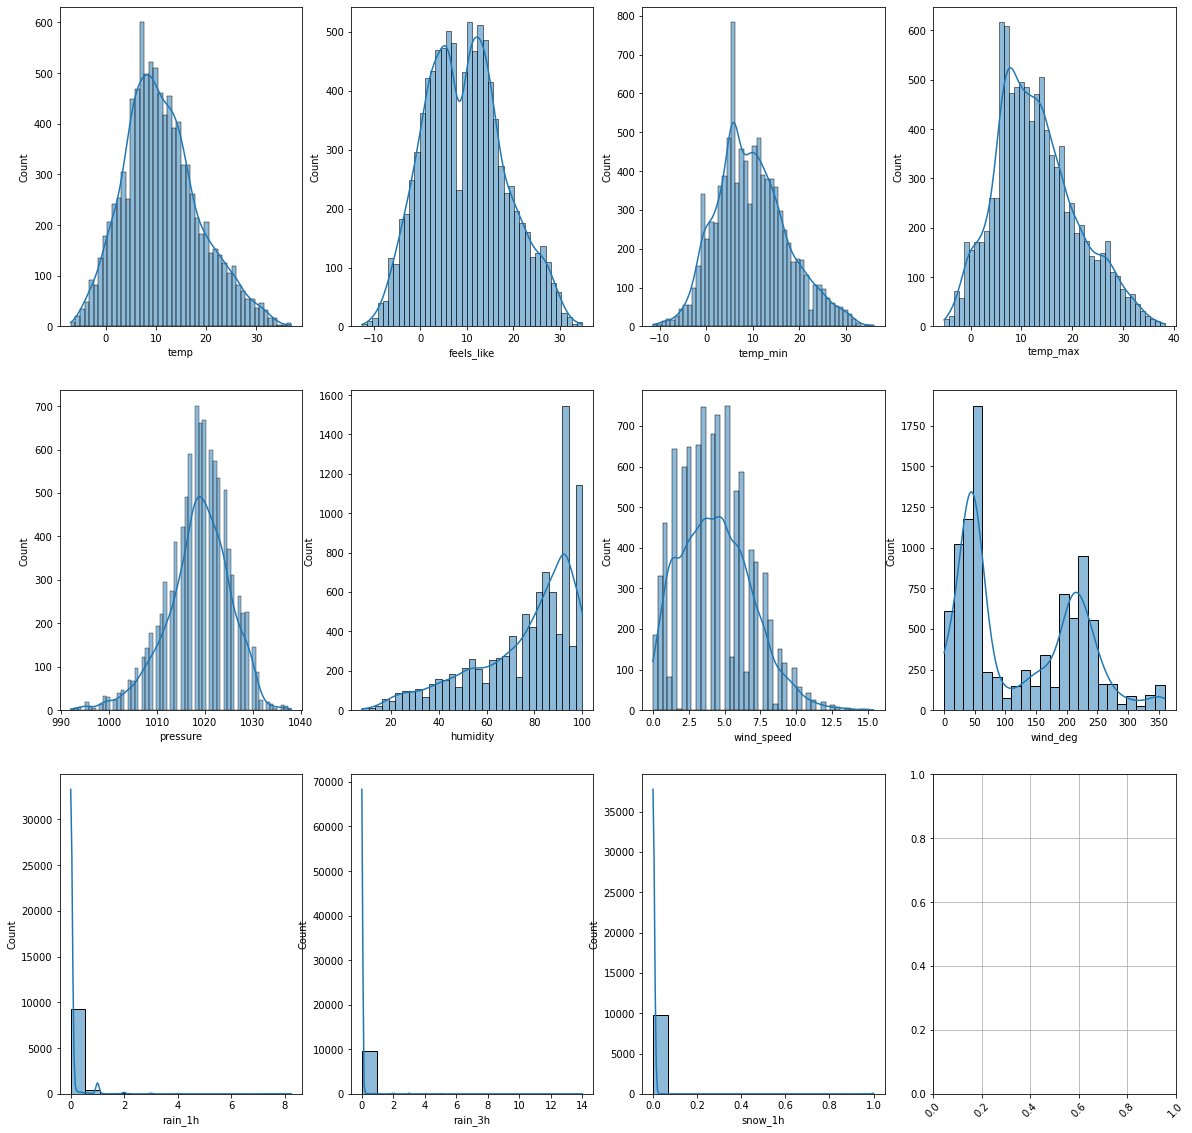

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 20))
i = 0
j = 0
for col in ['temp', 'feels_like', 'temp_min', 'temp_max',
            'pressure', 'humidity', 'wind_speed', 'wind_deg',
            'rain_1h', 'rain_3h', 'snow_1h']:
    if j == 4:
        j = 0
        i += 1
    ax = sns.histplot(x=weather[col], kde=True, ax=axs[i, j])
    plt.xticks(rotation=45)
    plt.grid()
    if i == 2 and j == 3:
        break
    j += 1
plt.show()


## Discrete feature distributions

c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


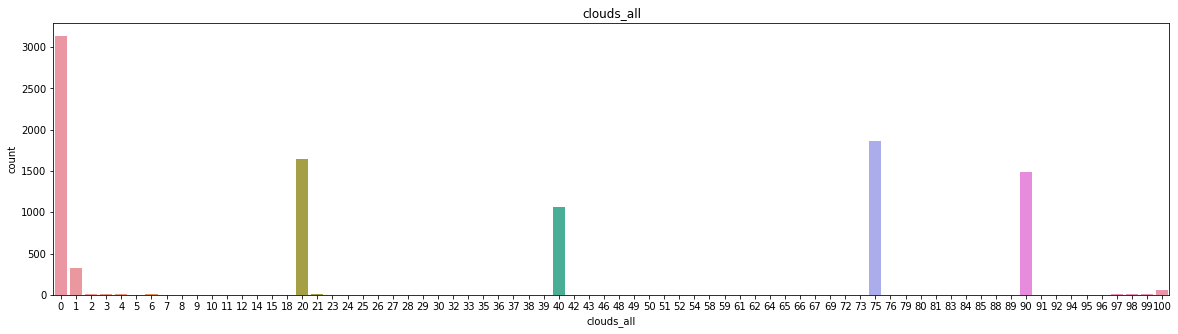

c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


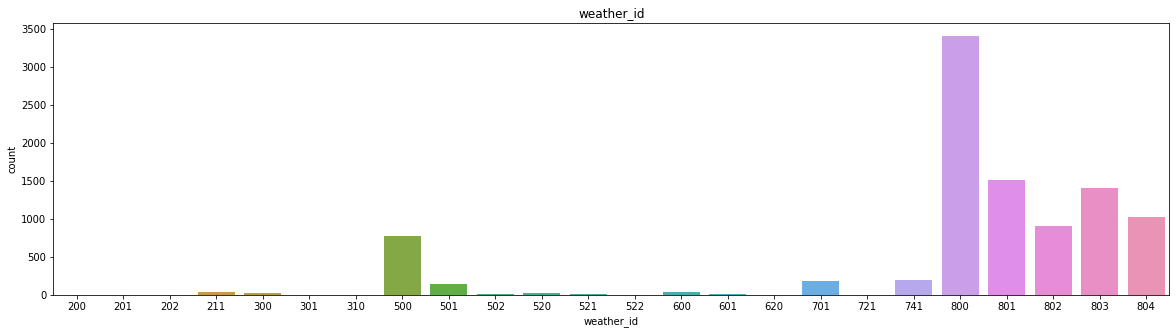

c:\Ubuntu\Dev\Windows\I-NERGY\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


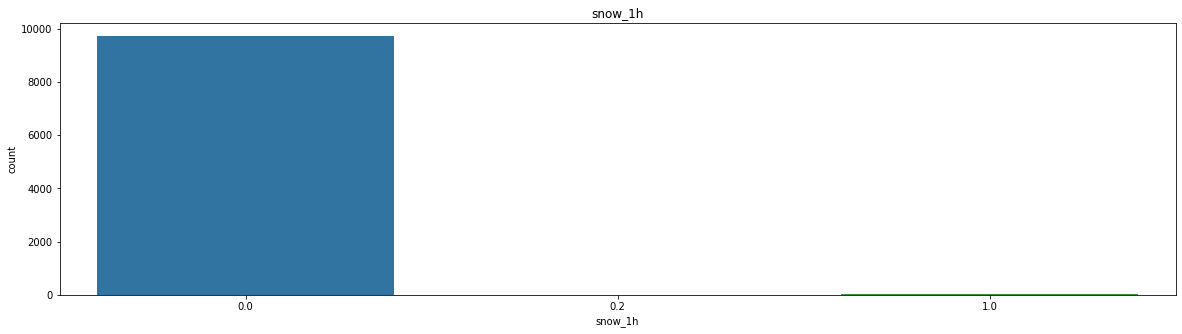

In [9]:
for col in ['clouds_all', 'weather_id', 'snow_1h']:
    plt.figure(figsize=(20, 5))
    sns.countplot(weather[col], )
    plt.title(col)
    plt.show()

## Comparison with VEOLIA measured temperatures

In [10]:
ts60 = pd.read_csv('../../VEOLIA/artifacts/timeseries_60min.csv',
                   index_col=0, parse_dates=True)[datetime.datetime(2020, 11, 6):]
veolia_temp = ts60['TEMPERATURA EXTERIOR (60 minuto)']
openweather_temp = weather['temp']
temp = pd.concat((veolia_temp, openweather_temp), axis=1)
diff = veolia_temp - openweather_temp


In [11]:
fig = px.line(temp)
fig.show()

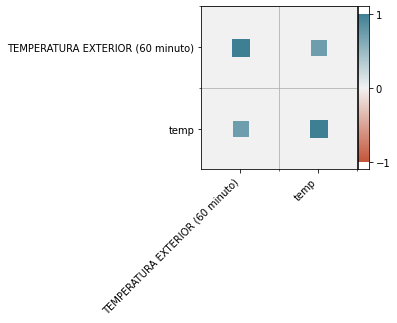

In [12]:
plt.figure(figsize=(3, 3))
corrplot(temp.corr(), size_scale=300)

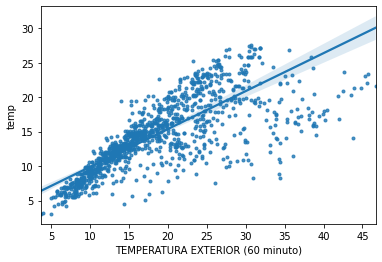

In [13]:
fig = sns.regplot(y="temp", x="TEMPERATURA EXTERIOR (60 minuto)", data=temp, marker='.', robust=True)

High correlation is observed between different temperatures so the ones from OpenWeatherMap will be kept for now as they are much more complete and combined with other weather features as well.

# Store curated dataset

In [14]:
weather.index.rename('datetime', inplace=True)
weather.to_csv('../../VEOLIA/artifacts/weather_curated_60min.csv')
weather.head()

,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,clouds_all,weather_id
datetime,,,,,,,,,,,,,
2020-06-10 02:00:00,5.51,2.72,4.94,7.03,1022,94,3.6,30,0.0,0.0,0.0,0,800
2020-06-10 03:00:00,5.13,2.97,4.88,6.53,1023,94,2.6,40,0.0,0.0,0.0,0,800
2020-06-10 04:00:00,5.73,2.99,5.28,6.47,1022,96,3.6,50,0.0,0.0,0.0,40,802
2020-06-10 05:00:00,4.68,2.89,4.38,6.03,1022,95,2.1,30,0.0,0.0,0.0,20,801
2020-06-10 06:00:00,4.00,1.63,3.78,4.80,1022,99,2.6,50,0.0,0.0,0.0,32,802
